# Simulating Prices of Coupon-Bearing Bond using CIR

In this section, we simulate bond prices of coupon-bearing bonds and see how their prices change as interest rates fluctuate. We'll limit ourselves to Treasury Bonds and ignore credit risk (i.e. the risk of default on the Bond).

But first, we will modify `discount` to return a DataFrame by iterating over all given interest rates and not just a single $ir$ value. Note that this is not a time series of interest rates, or a yield curve - it's just a vector of interest rates and the discount factor is recomputed for each interest rate

In [1]:
import pandas as pd
import numpy as np
from nsepy import get_history
import datetime
from scipy import stats
from scipy.optimize import minimize
import copy
import math

In [43]:
import Basic_Risk_Assessment_Tools as brat

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib as plt
%matplotlib inline

In [5]:
def discount(t, ir):
    """
    Compute the price of a pure discount bond that pays a dollar at time period t
    and r is the per-period interest rate
    returns a |t| x |r| Series or DataFrame
    r can be a float, Series or DataFrame
    returns a DataFrame indexed by t
    
    ASSUMPTION: The yield curve is flat that is the IR is the same
    for different horizons
    """
    discounts = pd.DataFrame([(ir+1)**-i for i in t])
    discounts.index = t
    return discounts

We will also update the code for `present_value` to accomodate a DataFrame input.

In [6]:
def present_value(liabilities, ir):
    """
    Compute the present value of a list of liabilities 
    'liabilities' are indexed by time and the values are 
    amounts of each liability returns the present value of
    the sequence
    """
    dates = liabilities.index
    discounts = discount(dates, ir)
    return discounts.multiply(liabilities, axis='rows').sum()

In [7]:
brat.bond_price(5,100,.05,12,.03)

0    109.275393
dtype: float64

To generate Interest Rates using CIR model:

In [8]:
# r_0 sets the first Interest Rate at 0.03 and keeps it the same across all scenarios
rates, zc_prices = brat.cir(10, 500, b=0.03, r_0 = 0.03)

Bond Prices at t=0 can be given by:

In [9]:
brat.bond_price(5,100,.05,12, rates.iloc[0]).head()

0    109.275393
1    109.275393
2    109.275393
3    109.275393
4    109.275393
dtype: float64

They're all the same price because we set r_0 as 0.03.

At t=1, the bond prices are different.....

In [27]:
brat.bond_price(5-1/12,100,.05,12, rates.iloc[1]).head()

0    108.776866
1    108.715134
2    107.977178
3    110.611432
4    108.313783
dtype: float64

To make it possible to simulate a DataFrame of Bond Prices when we get an input of multiple scenarios of simulated interest rates, we modify `bond_price`

In [11]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return present_value(cash_flows, discount_rate/coupons_per_year)

Simulating the price of a 10 year bond over 5 scenarios of Interest Rate changes we get the following:

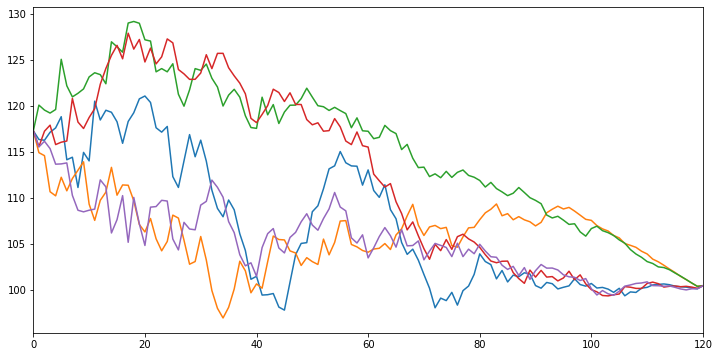

In [12]:
brat.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]]).plot(legend=False, figsize=(12,6))

The idea is to create a set of simulated $Total Bond Returns$ $(CouponReturns+PriceReturns)$ and then use a $Simulated Stock Return$ to build a mixed portfolio of stocks and bonds

### Simulated Total Bond Returns

In [13]:
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvested in the bond
    """
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [14]:
prices = brat.bond_price(10, 100, .05, 12, rates[[1,2,3,4,5]])
total_bond_returns = brat.bond_total_return(prices, 100, 0.05, 12)
total_bond_returns.head()

,1,2,3,4,5
1,-0.0044503,-0.0166907,0.0273898,-0.0111179,-0.0113533
2,0.00282137,0.000787311,-0.00103159,0.0181439,0.00890877
3,0.0110405,-0.030601,0.00076494,0.00915738,-0.00326776
4,0.00763003,-0.000270223,0.00676475,-0.0143689,-0.0110855
5,0.0139158,0.0221153,0.0491031,0.00581614,0.00393152


In [15]:
returns = {}
for head in list(total_bond_returns.columns):
    returns[head] = pd.DataFrame(total_bond_returns[head], columns=[head])
brat.get_AnnVol_AnnRet_Ret2Risk_Sharpe(returns, annualizing_factor=12)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio
1,0.052975,0.031940,0.602922,-0.493829
2,0.046667,0.032123,0.688352,-0.556651
3,0.036049,0.028376,0.787173,-0.824543
4,0.036395,0.029811,0.819084,-0.777276
5,0.050582,0.032511,0.642737,-0.505884


Which gives us the approximately 3% return we expected, because that was the prevailing rate when we bought it. We also assumed that we reinvested the coupon in the bond and that is why we did not get the exact same return in each case, since we would observe prices based on the then-prevalent interest rates.

In [16]:
prices.tail()

,1,2,3,4,5
116,100.301,101.431,101.464,100.31,100.067
117,100.266,101.09,101.087,100.355,99.9659
118,100.176,100.707,100.715,100.27,100.087
119,100.09,100.364,100.347,100.137,100.082
120,100.417,100.417,100.417,100.417,100.417


We see here that the simulated prices of all the bonds approach the value of the $Last$ $Coupon+Principal$ payment, which is in line with reality. 

Looking at the price of a 20 year bond at the end of 10 years, we don't see a similar convergence because there are still another 10 years left to maturity....

In [52]:
price_20 = brat.bond_price(20, 100, .05, 12, rates)
price_20.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
116,116.619,107.672,142.853,144.043,107.91,101.655,116.434,148.485,121.834,130.96,...,120.284,142.262,114.386,127.775,119.606,135.214,108.998,104.332,115.618,131.512
117,118.475,109.031,143.284,143.179,112.246,98.907,115.908,147.887,120.56,132.588,...,121.63,138.82,114.874,126.711,124.592,135.562,108.94,106.432,115.872,130.553
118,121.609,108.898,141.516,142.131,114.01,104.284,112.19,148.308,122.431,134.074,...,123.503,136.266,115.212,127.736,124.435,135.902,110.477,108.055,115.867,128.578
119,119.717,108.993,142.702,140.275,114.042,108.126,114.069,147.957,124.424,133.817,...,121.211,136.682,114.965,126.942,125.959,136.687,112.272,107.038,120.795,128.711
120,116.795,113.225,142.035,138.358,114.547,105.685,114.296,146.565,123.686,134.284,...,117.292,136.289,110.223,126.262,128.067,134.171,111.55,106.253,117.654,126.227


### Bond Portfolio
Creating a portfolio of $60$% $10y$ $bond$ and $40$% $30y$ $bond$  we get....

In [28]:
price_10 = brat.bond_price(10, 100, .05, 12, rates)
price_10.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
116,100.624,100.301,101.431,101.464,100.31,100.067,100.617,101.583,100.799,101.087,...,100.748,101.415,100.546,100.989,100.725,101.214,100.351,100.173,100.589,101.104
117,100.519,100.266,101.09,101.087,100.355,99.9659,100.453,101.183,100.572,100.858,...,100.599,100.995,100.426,100.722,100.671,100.925,100.264,100.192,100.452,100.812
118,100.402,100.176,100.707,100.715,100.27,100.087,100.238,100.8,100.416,100.599,...,100.433,100.631,100.292,100.501,100.448,100.626,100.206,100.16,100.303,100.514
119,100.186,100.09,100.364,100.347,100.137,100.082,100.137,100.4,100.226,100.3,...,100.199,100.321,100.145,100.246,100.238,100.321,100.12,100.071,100.196,100.26
120,100.417,100.417,100.417,100.417,100.417,100.417,100.417,100.417,100.417,100.417,...,100.417,100.417,100.417,100.417,100.417,100.417,100.417,100.417,100.417,100.417


In [29]:
price_30 = brat.bond_price(30, 100, .05, 12, rates)
price_30.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
116,128.336,112.573,181.476,184.132,112.977,102.638,127.998,194.241,138.074,156.098,...,135.137,180.165,124.289,149.666,133.865,164.929,114.834,106.992,126.514,157.229
117,131.899,114.953,182.875,182.641,120.57,98.2728,127.159,193.374,135.821,159.744,...,137.859,173.008,125.277,147.778,143.594,165.999,114.795,110.524,127.094,155.539
118,137.995,114.784,179.353,180.73,123.822,106.968,120.56,194.877,139.583,163.173,...,141.668,167.85,126.006,150.071,143.493,167.068,117.535,113.334,127.205,151.775
119,134.545,115.014,182.461,177.008,123.987,113.512,124.037,194.588,143.683,162.953,...,137.407,169.108,125.67,148.712,146.737,169.118,120.797,111.645,136.607,152.306
120,129.18,122.609,181.401,173.16,125.02,109.386,124.56,191.855,142.433,164.283,...,130.11,168.62,117.239,147.579,151.249,164.041,119.596,110.351,130.791,147.508


In [44]:
returns_10 = brat.bond_total_return(price_10, 100, .05, 12)
returns_30 = brat.bond_total_return(price_30, 100, .05, 12)
returns_bond_port = 0.6*returns_10 + 0.4*returns_30

In [47]:
# Computing the Summary Stats for the average return of the 500 different bond scenarios
mean_returns_bonds = returns_bond_port.mean(axis="columns")
brat.summary_stats({'Mean Bond Returns': pd.DataFrame(data=mean_returns_bonds, columns=['Mean Bond Returns'])}, annualizing_factor=12, risk_free_return=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
Mean Bond Returns,0.003591,0.035672,9.93369,1.537289,-0.034351,0.002926,0.002876,True,-0.006144,0.932034,True,0.00002,-0.001228,-0.001245,-0.000738,-0.001447


### Simulated Equity Returns/Portfolio

In [48]:
price_equity = brat.geo_brown_motion(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15, steps_per_year=12)
returns_equity = price_equity.pct_change().dropna()
returns_equity.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,-0.043748,-0.009336,-0.041594,-0.040632,0.056196,0.079002,-0.036525,-0.003077,-0.015078,0.029197,...,0.080376,0.059153,0.062359,-0.040419,-0.015390,0.064153,0.037080,-0.033037,-0.105850,0.033056
2,0.050270,0.043020,-0.074982,0.028938,-0.068920,-0.015989,0.060184,0.018953,0.032301,-0.062825,...,-0.052021,-0.014868,0.023727,-0.019514,0.069072,-0.037952,-0.060005,0.028316,-0.029727,0.000869
3,-0.008330,0.045267,0.036196,-0.064799,-0.000587,0.050914,0.010547,-0.024383,0.036687,0.007807,...,-0.055877,0.000697,0.004395,-0.033014,0.020054,0.064929,0.023815,0.012742,0.021706,-0.001194
4,-0.054625,0.023480,-0.043179,-0.044739,0.053700,-0.002004,-0.037779,-0.059934,0.075802,-0.040547,...,-0.021124,0.028039,0.006434,0.007306,-0.003016,-0.029341,-0.012117,0.081520,0.067953,0.027965
5,0.069533,0.062171,0.054703,0.076430,0.019148,0.055800,0.056616,-0.000502,-0.038689,-0.001744,...,0.000765,0.031186,0.039877,0.007327,-0.050227,-0.024852,-0.096206,-0.059752,0.006417,0.018769


In [49]:
returns_equity.shape

(120, 500)

In [22]:
returns_bond_port.shape

(120, 500)

### Combined Portfolio Performance

As the returns of the Bonds and Stocks are of the same shape,
we can combine them to form a portfolio of $70$% $stocks$ and $30$% $bonds$

In [50]:
portfolio_returns = 0.7*returns_equity + 0.3*returns_bond_port
mean_portfolio_returns = portfolio_returns.mean(axis='columns')
brat.summary_stats({'Mean Portfolio Returns': pd.DataFrame(data=mean_portfolio_returns, columns=['Mean Portfolio Returns'])}, annualizing_factor=12, risk_free_return=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
Mean Portfolio Returns,0.004238,0.061561,14.526027,7.248313,0.0,0.004991,0.005006,False,-0.159844,-0.449477,True,NaN,-0.002988,-0.002922,-0.002519,-0.003027


It is evident that the Annualised Returns for the combined portfolio is 6%, which is an improvement from the 3.5% return from the Bond Portfolio. The Sharpe Ratio also shows a tremendous improvement to 7%.

However, this greater return also comes with an added risk which can be seen in the higher Value at Risk parameters.